# Code 

## Exploring the dataset

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1995 entries, 0 to 2000
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   bmi                    1995 non-null   float64
 1   age                    1995 non-null   int64  
 2   country                1882 non-null   object 
 3   been_pregnant_before   1678 non-null   object 
 4   education              1604 non-null   object 
 5   sleeping_pattern       1496 non-null   object 
 6   n_cycles_trying        1995 non-null   int64  
 7   outcome                1995 non-null   object 
 8   dedication             1995 non-null   float64
 9   average_cycle_length   1989 non-null   float64
 10  cycle_length_std       1970 non-null   float64
 11  regular_cycle          1989 non-null   object 
 12  intercourse_frequency  1995 non-null   float64
dtypes: float64(5), int64(2), object(6)
memory usage: 218.2+ KB
Length of dataframe =  1995
Null values = 
 bmi  

<Figure size 432x288 with 0 Axes>

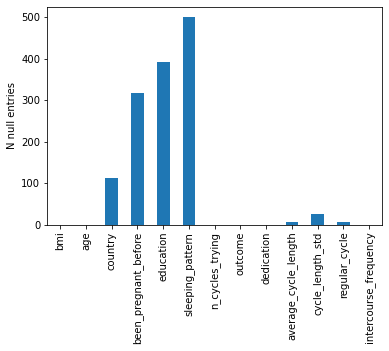

In [7]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.special import gamma, factorial 
from scipy.optimize import curve_fit
from scipy import integrate
import scipy.stats as st
from itertools import chain, tee

# open file
df = pd.read_csv('NCDataChallenge_2021_v1.csv', index_col=0, )

# explore dataset head/tail, columns, length
df.head()
df.tail()
df.info()
df.dtypes
df_len = len(df)
print('Length of dataframe = ',df_len)
col_index = df.index

# check for missing indices
i1, i2 = tee(map(lambda x: int(x), col_index), 2)
next(i2) 
list(chain.from_iterable(range(i+1, j) for i, j in zip(i1, i2) if j-i!=1))

# check for missing data in each column
null_sum = df.isna().sum()
percent_null = (null_sum/df_len)*100
print('Null values = \n',null_sum)
print('Null values in percentage = \n', percent_null)
plt.figure()
null_sum.reset_index(name="Null").plot.bar(x='index', y='Null', rot=90, legend=None)
plt.ylabel('N null entries')
plt.xlabel('')
plt.savefig('plots/null_vals.pdf', bbox_inches='tight')

## Analysis

### Q1 What is the chance of getting pregnant within 13 cycles?

In [8]:
# Get the subset of dataframe and numbers to compute the probability and its uncertainty
df_preg = df.loc[df['outcome'] == 'pregnant']
df_preg_in13 = df_preg.loc[df_preg['n_cycles_trying'] < 14]
n = len(df_preg)
ntot = len(df)
npreg = len(df_preg_in13)

p = npreg/ntot

unc_ntot = np.sqrt(ntot)
unc_npreg = np.sqrt(npreg)
unc_p = np.sqrt(np.power((unc_ntot/ntot),2) + np.power((unc_npreg/npreg),2))*p

print ('Total number of women = ', ntot)
print ('Number of women that got pregnant = ', n)
print ('Number of women that got pregnant within 13 cycles = ', npreg)
print('Probability of getting pregnant within 13 cycles = ',p ,' +/- ', unc_p)


Total number of women =  1995
Number of women that got pregnant =  1148
Number of women that got pregnant within 13 cycles =  1148
Probability of getting pregnant within 13 cycles =  0.5754385964912281  +/-  0.02131713249374552


#### Further investigation

Maximum N cycles =  26
Maximum N cycles to get pregnant =  13
Women not pregnant (within 13 cycles) =  847


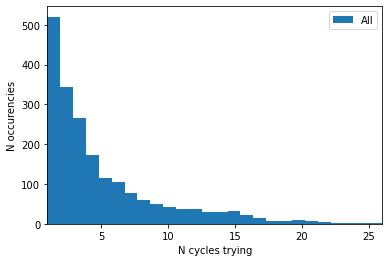

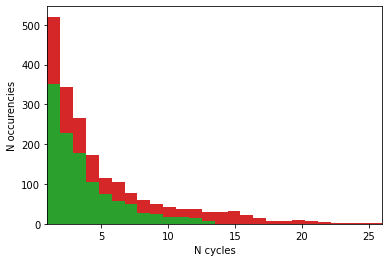

In [37]:
# Maximum number of cycles
max_ntries = df['n_cycles_trying'].max()
max_ntries_preg = df_preg['n_cycles_trying'].max()
print('Maximum N cycles = ', max_ntries)
print('Maximum N cycles to get pregnant = ', max_ntries_preg)

df_more13 = df.loc[df['outcome'] == 'not_pregnant']
nmore13 = len(df_more13)
print('Women not pregnant (within 13 cycles) = ', nmore13)

# plot all 
plt.figure()
df['n_cycles_trying'].plot(kind='hist',x='Ncycles', bins = max_ntries,label='All')
plt.xlim(1,max_ntries)
plt.xlabel('N cycles trying')
plt.ylabel('N occurencies')
plt.legend()

# get df not pregnant
df_notpreg = df_more13

# plot pregnant and not pregnant stack
plt.figure()
df_preg['n_cycles_trying'].plot(kind='hist',x='Ncycles', bins = max_ntries,stacked=True)
df_notpreg['n_cycles_trying'].plot(kind='hist',x='Ncycles', bins = max_ntries,stacked=True)


plt.hist([df_preg['n_cycles_trying'],df_notpreg['n_cycles_trying']],
          bins=max_ntries, range=(1,max_ntries), stacked=True)
plt.xlim(1,max_ntries)
plt.xlabel('N cycles')
plt.ylabel('N occurencies')
#plt.legend(['Pregnant','Not pregnant'])
plt.savefig('plots/preg_notpreg.pdf', bbox_inches='tight')

### Q2 How long does it usually take to get pregnant?

Mean value from fit =  1.832792224447186  +/-  1.353806568327686
Mean value from dataframe =  3.3754355400696863  +/-  2.733305078852353


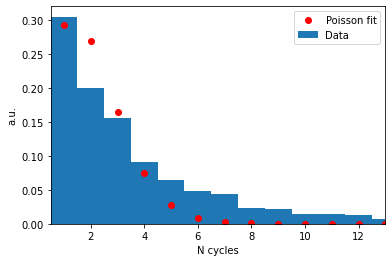

In [38]:
# define Poisson function used for fitting

def poiss(n,m):
    y = (np.power(m,n)/factorial(n))*np.exp(-m)
    return y


bins_list = np.arange(start=1,stop=(max_ntries_preg+2),step=1) - 0.5
yields,b_edges,_ =plt.hist(df_preg['n_cycles_trying'],bins=bins_list,label='Data',density=True)
b_middles = 0.5 * (b_edges[1:] + b_edges[:-1])

# fit
fitres, _ = curve_fit(poiss, b_middles, yields, p0=[1])
# plot curve
plt.plot(b_middles, poiss(b_middles, *fitres), label='Poisson fit', c='red',marker='o', linestyle='')

plt.xlim(0.5,max_ntries_preg)
plt.xlabel('N cycles')
plt.ylabel('a.u.')
plt.legend()

plt.savefig('plots/fit_preg.pdf', bbox_inches='tight')

mean_preg = fitres[0]
err_mean_preg = np.sqrt(mean_preg)

print('Mean value from fit = ', mean_preg, ' +/- ', err_mean_preg)

mean_df = df_preg['n_cycles_trying'].mean()
std_df = df_preg['n_cycles_trying'].std()

print('Mean value from dataframe = ', mean_df, ' +/- ', std_df)

### Q3  What factors impact the time it takes to get pregnant?

In [17]:
# Pearson correlation coefficient
col_ntries = df_preg['n_cycles_trying']
col_bmi    = df_preg['bmi']
col_age    = df_preg['age']
col_dedic  = df_preg['dedication']
col_leng   = df_preg['average_cycle_length']
col_freq   = df_preg['intercourse_frequency']

correl_bmi   = col_ntries.corr(col_bmi)
correl_age   = col_ntries.corr(col_age)
correl_dedic = col_ntries.corr(col_dedic)
correl_leng  = col_ntries.corr(col_leng)
correl_freq  = col_ntries.corr(col_freq)

print('Correlation N tries with bmi = ', correl_bmi)
print('Correlation N tries with age = ', correl_age)
print('Correlation N tries with dedication = ', correl_dedic)
print('Correlation N tries with average cycle length = ', correl_leng)
print('Correlation N tries with intercourse frequency = ', correl_freq)

Correlation N tries with bmi =  -0.006395353322517538
Correlation N tries with age =  0.13354122494050277
Correlation N tries with dedication =  -0.17614729887122293
Correlation N tries with average cycle length =  -0.04832258185459994
Correlation N tries with intercourse frequency =  -0.19532418192414452


<Figure size 432x288 with 0 Axes>

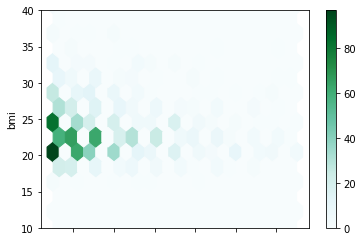

<Figure size 432x288 with 0 Axes>

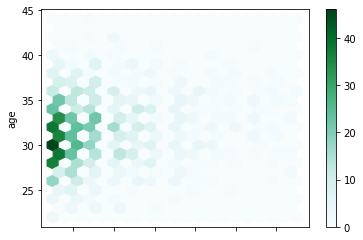

<Figure size 432x288 with 0 Axes>

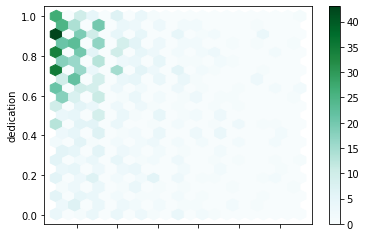

<Figure size 432x288 with 0 Axes>

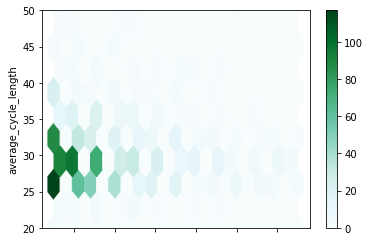

<Figure size 432x288 with 0 Axes>

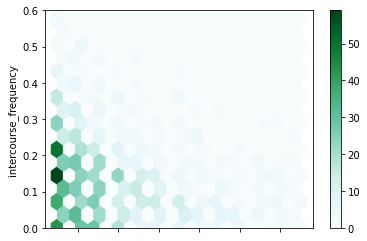

In [18]:
plt.figure()
df_preg.plot.hexbin(x='n_cycles_trying',y='bmi',gridsize=20)
plt.ylim(10,40)
plt.savefig('plots/hex_bmi.pdf', bbox_inches='tight')

plt.figure()
df_preg.plot.hexbin(x='n_cycles_trying',y='age',gridsize=20)
plt.savefig('plots/hex_age.pdf', bbox_inches='tight')

plt.figure()
df_preg.replace(0, np.nan).plot.hexbin(x='n_cycles_trying',y='dedication',gridsize=20)
plt.savefig('plots/hex_dedic.pdf', bbox_inches='tight')

plt.figure()
df_preg.replace(0, np.nan).plot.hexbin(x='n_cycles_trying',y='average_cycle_length',gridsize=20)
plt.ylim(20,50)
plt.savefig('plots/hex_len.pdf', bbox_inches='tight')

plt.figure()
df_preg.plot.hexbin(x='n_cycles_trying',y='intercourse_frequency',gridsize=20)
plt.ylim(0.,0.6)
plt.savefig('plots/hex_freq.pdf', bbox_inches='tight')

m=  -0.0062886464134570275  b =  0.1675926701085094


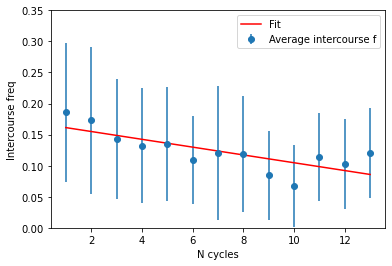

In [39]:
# intercourse frequency

list_mean = []
list_std=[]
for i in range(max_ntries_preg):
    col_fr = df_preg.loc[df_preg['n_cycles_trying'] == i+1]['intercourse_frequency']
    c_mean = col_fr.replace(0, np.nan).mean()
    c_std = col_fr.replace(0, np.nan).std()
    list_mean.append(c_mean)
    list_std.append(c_std)

ncycles = list(range(1,max_ntries_preg+1))
plt.figure()
plt.errorbar(ncycles,list_mean, yerr = list_std,label='Average intercourse f',fmt='o')
m,b = np.polyfit(ncycles, list_mean, 1)
print('m= ',m, ' b = ',b)
ncycles_arr=np.asarray(ncycles)

plt.plot(ncycles, m*(ncycles_arr) + b,c='red',label='Fit')
plt.ylim(0.,0.35)
plt.xlabel('N cycles')
plt.ylabel('Intercourse freq')
plt.legend()
plt.savefig('plots/mean_freq.pdf', bbox_inches='tight')

m=  -0.013721622014526862  b =  0.6666537183231399


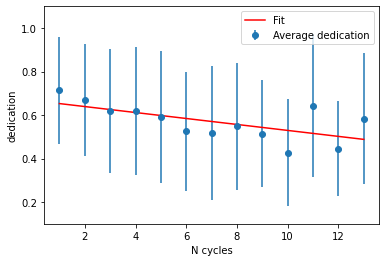

In [43]:
# dedication

list_mean = []
list_std=[]
for i in range(max_ntries_preg):
    col_fr = df_preg.loc[df_preg['n_cycles_trying'] == i+1]['dedication']
    c_mean = col_fr.replace(0, np.nan).mean()
    c_std = col_fr.replace(0, np.nan).std()
    list_mean.append(c_mean)
    list_std.append(c_std)

ncycles = list(range(1,max_ntries_preg+1))
plt.figure()
plt.errorbar(ncycles,list_mean, yerr = list_std,label='Average dedication',fmt='o')
m,b = np.polyfit(ncycles, list_mean, 1)
print('m= ',m, ' b = ',b)
ncycles_arr=np.asarray(ncycles)

plt.plot(ncycles, m*(ncycles_arr) + b,c='red',label='Fit')
plt.ylim(0.1,1.1)
plt.xlabel('N cycles')
plt.ylabel('dedication')
plt.legend()
plt.savefig('plots/mean_dedic.pdf', bbox_inches='tight')

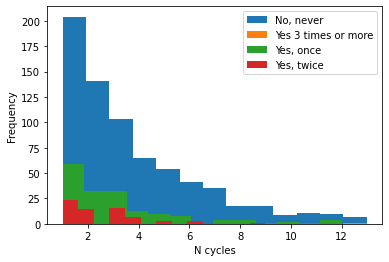

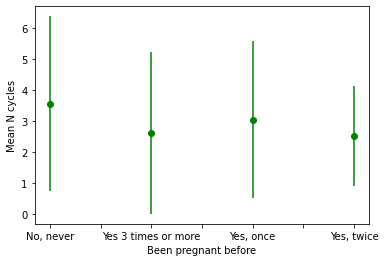

In [66]:
# Look at different classes for non-numerical values

#Check possible values in the been_pregnant_before column
col_beenpreg = df_preg['been_pregnant_before']
df_preg.been_pregnant_before.unique()

means= df_preg.groupby(['been_pregnant_before'])['n_cycles_trying'].mean()
stds= df_preg.groupby(['been_pregnant_before'])['n_cycles_trying'].std()

plt.figure()
df_preg.groupby(['been_pregnant_before'])['n_cycles_trying'].plot(kind='hist',bins=13)
plt.xlabel('N cycles')
plt.legend()
plt.savefig('plots/preg_bef.pdf', bbox_inches='tight')

plt.figure()
means.plot(yerr=stds,fmt='o',color='green')
plt.ylabel('Mean N cycles')
plt.xlabel('Been pregnant before')
plt.savefig('plots/preg_bef_mean.pdf', bbox_inches='tight')

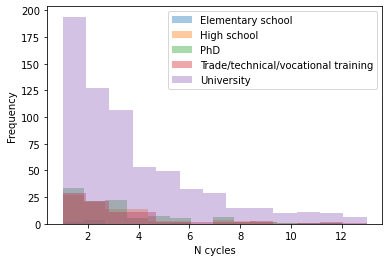

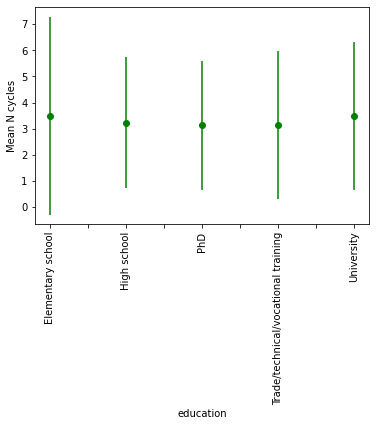

In [67]:
#Check possible values in the education column
col_beenpreg = df_preg['education']
df_preg.education.unique()

means= df_preg.groupby(['education'])['n_cycles_trying'].mean()
stds= df_preg.groupby(['education'])['n_cycles_trying'].std()

plt.figure()
df_preg.groupby(['education'])['n_cycles_trying'].plot(kind='hist',bins=13, alpha=0.4)
plt.xlabel('N cycles')
plt.legend()
plt.savefig('plots/edu.pdf', bbox_inches='tight')

plt.figure()
means.plot(yerr=stds,rot=90,fmt='o',color='green')
plt.ylabel('Mean N cycles')
plt.savefig('plots/edu_mean.pdf', bbox_inches='tight')

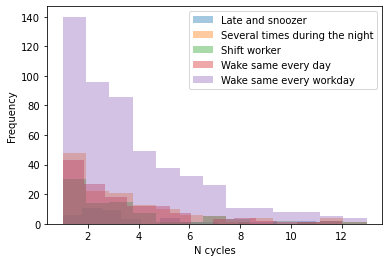

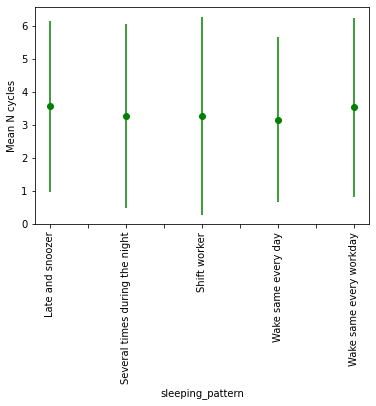

In [71]:
#Check possible values in the sleeping_pattern column
col_beenpreg = df_preg['sleeping_pattern']
df_preg.sleeping_pattern.unique()

means= df_preg.groupby(['sleeping_pattern'])['n_cycles_trying'].mean()
stds= df_preg.groupby(['sleeping_pattern'])['n_cycles_trying'].std()


plt.figure()
df_preg.groupby(['sleeping_pattern'])['n_cycles_trying'].plot(kind='hist',bins=13,  alpha=0.4)
plt.xlabel('N cycles')
plt.legend()
plt.savefig('plots/sleep.pdf', bbox_inches='tight')

plt.figure()
means.plot(yerr=stds,rot=90,fmt='o',color='green')
plt.ylabel('Mean N cycles')
plt.savefig('plots/sleep_mean.pdf', bbox_inches='tight')

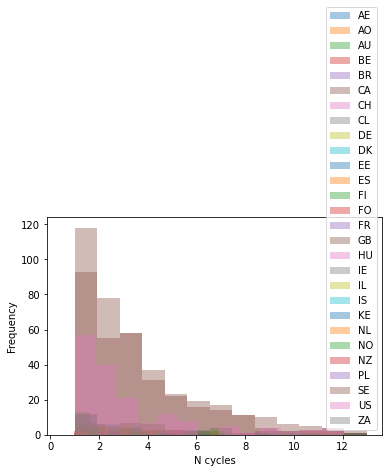

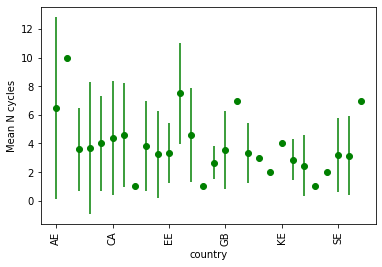

In [73]:
#Check possible values in the country column
col_beenpreg = df_preg['country']
df_preg.country.unique()

means= df_preg.groupby(['country'])['n_cycles_trying'].mean()
stds= df_preg.groupby(['country'])['n_cycles_trying'].std()


plt.figure()
df_preg.groupby(['country'])['n_cycles_trying'].plot(kind='hist',bins=13,  alpha=0.4)
plt.xlabel('N cycles')
plt.legend()
plt.savefig('plots/country.pdf', bbox_inches='tight')

plt.figure()
means.plot(yerr=stds,rot=90,fmt='o',color='green')
plt.ylabel('Mean N cycles')
plt.savefig('plots/country_mean.pdf', bbox_inches='tight')

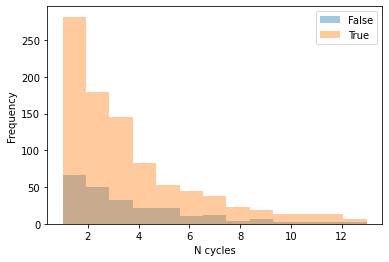

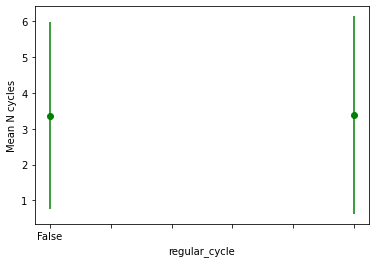

In [76]:
#Check possible values in the regular_cycle column
col_beenpreg = df_preg['regular_cycle']
df_preg.regular_cycle.unique()

means= df_preg.groupby(['regular_cycle'])['n_cycles_trying'].mean()
stds= df_preg.groupby(['regular_cycle'])['n_cycles_trying'].std()


plt.figure()
df_preg.groupby(['regular_cycle'])['n_cycles_trying'].plot(kind='hist',bins=13,  alpha=0.4)
plt.xlabel('N cycles')
plt.legend()
plt.savefig('plots/reg.pdf', bbox_inches='tight')

plt.figure()
means.plot(yerr=stds,fmt='o',color='green')
plt.ylabel('Mean N cycles')
plt.savefig('plots/reg.pdf', bbox_inches='tight')